### Steps to be followed:

1. Import necessary libraries
2. Creating S3 Bucket
3. Get Data and create Train, Test and validation Set.
4. Upload Data to S3 Bucket
5. Download or Build and Train Model in SageMaker
6. Deploy the model
7. Making Prediction on the model
8. Generate Confusion Matrix
9. Delete the SageMaker Endpoint

#### 1. Import necessary libraries

- **sagemaker** - To use sagemaker functions
- **boto3** - To access S3 buckets given the puble access is provided to S3.
- **amazon_estimator** -  To use the in-built sagemaker ML models. 
- **get_image_uri** - The URL from where we will pick the in-built model
- **session** - To use a instance of sagemaker we have to create a session
- **s3_input** - To get the information from S3.

In [3]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input, Session

#### 2. Creating S3 bucket.

You can create this in AWS and then use it or you can create it using Python with boto3. Here we will use boto3.

#### Required:

**1. bucket_name:** The name of the S3 bucket we want to create. The name has to be unique globally. Else you will get already exist error.

**2. my_region:** The region we want to create S3 bucket. Impacts the speed so use the region you are closer to. That's where your data center will be. So faster speed,

In [12]:
# Name of the S3 Bucket we want to create.
bucket_name = "bankapplication-gs"

# Name of the region where the S3 bucket will be created.
# my_region = "us-east-2"
my_region = boto3.session.Session().region_name

print(my_region)

us-east-2


In [14]:
s3 = boto3.resource("s3")
try:
    if my_region == "us-east-2":
        s3.create_bucket(Bucket = bucket_name, CreateBucketConfiguration={'LocationConstraint': my_region})
    print("Success: S3 Bucket Created Successfuly")
except Exception as e:
    print("S3 Error : ", e)

S3 Bucket Created Successfuly


In [15]:
# Set an output path where the trained model will be saved.
prefix = "xgboost-as-a-built-in-algo"
output_path = "s3://{}/{}/output".format(bucket_name, prefix)
print(output_path)

s3://bankapplication-gs/xgboost-as-a-built-in-algo/output


#### 3. Get Data and create Train, Test and validation Set.

In [16]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print("Data Load Error: ", e)

Success: downloaded bank_clean.csv.


In [17]:
try:
    model_data = pd.read_csv("./bank_clean.csv", index_col = 0)
    print("Success: Data Loaded into Dataframe")
except Exception as e:
    print("Data Load Error: ", e)

Success: Data Loaded into Dataframe


In [18]:
# Note here we are not spliting the Test and Train data with train_test_split.
# As we want a copy of Test and Train data to store in S3.
import numpy as np
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


#### 4. Upload Data to S3 Bucket

In [23]:
# Note: For SageMaker it is advised to have the first column as the output column or the lable column or the prediction column.
import os
pd.concat([train_data["y_yes"], train_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv("train.csv", index=False, header=False)
    
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train/train.csv")).upload_file("train.csv")
s3_input_train = s3_input(s3_data="s3://{}/{}/train".format(bucket_name, prefix), content_type = "csv")


The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [24]:
# Note: For SageMaker it is advised to have the first column as the output column or the lable column or the prediction column.
import os
pd.concat([test_data["y_yes"], test_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv("test.csv", index=False, header=False)
    
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "test/test.csv")).upload_file("test.csv")
s3_input_test = s3_input(s3_data="s3://{}/{}/test".format(bucket_name, prefix), content_type = "csv")


The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### We can see the Train and Resr directory created in the S3 Bucket.

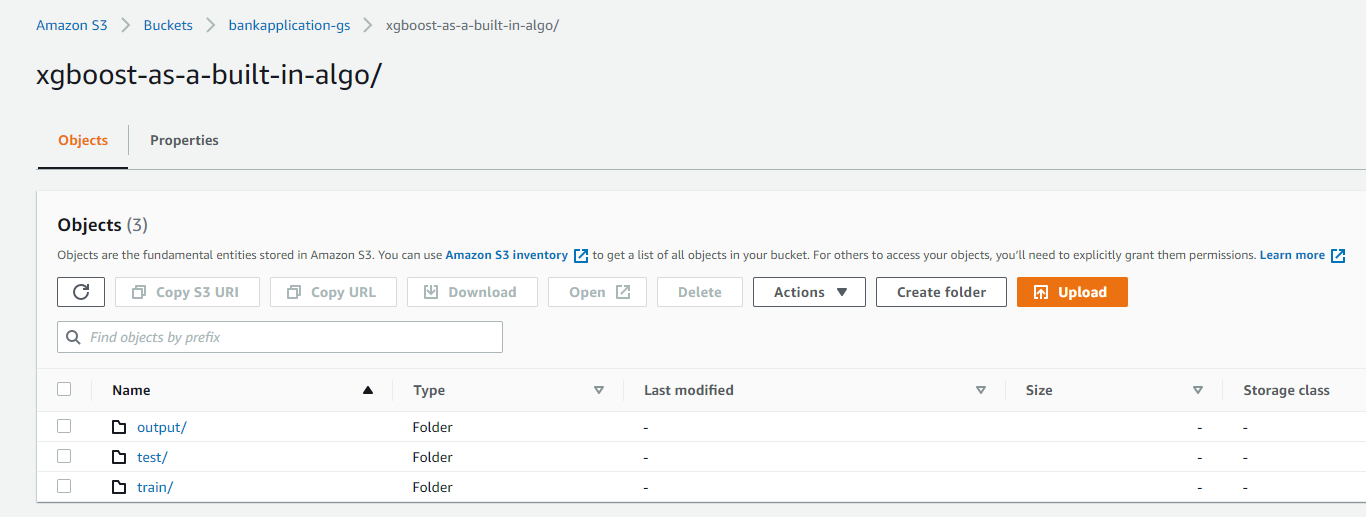

#### 5. Download or Build and Train Model in SageMaker

#### Build Model. 

We are using an In Built Algorithm. The in built model are available in sagemaker as an image or a container. We need to pull the one we want to use. 

#### Pull Image
**get_image_uri:** Helps us to pull the model.

The method below will pull the model.

In [25]:
container = get_image_uri(boto3.Session().region_name, "xgboost", repo_version="1.0-1")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


**Note:** Here we are not tuning the Hypeparameter in SageMaker as it will cost us money.

In [26]:
# Initalize Hyperparameter
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

#### Construct a sagemaker estimator that calls the model container. In this case XGBoost Container.

In [30]:
estimator = sagemaker.estimator.Estimator(image_uri=container,
                                         hyperparameters=hyperparameters,
                                         role=sagemaker.get_execution_role(),
                                         train_instance_count=1,
                                         train_instance_type="ml.m5.2xlarge",
                                         train_volume_size=5,
                                         output_path=output_path,
                                         train_use_spot_instances=True,
                                         train_max_run=300,
                                         train_max_wait=600)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The 3 parameters below helps us reduce the AWS service cost.

- `train_use_spot_instances=True,`
- `train_max_run=300,`
- `train_max_wait=600`

**Note:** How we are fitting the model here. It looks like a JSON. That's because SageMaker API will take and Return JSON.

In [31]:
# estimator.fit({"train": s3_input_train, "validation": s3_input_test})

2022-05-02 02:22:27 Starting - Starting the training job...
2022-05-02 02:22:29 Starting - Launching requested ML instancesProfilerReport-1651458147: InProgress
......
2022-05-02 02:23:53 Starting - Preparing the instances for training.........
2022-05-02 02:25:23 Downloading - Downloading input data
2022-05-02 02:25:23 Training - Downloading the training image...
2022-05-02 02:25:52 Uploading - Uploading generated training model
2022-05-02 02:25:52 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input

**Note:** Every time we train the model or re run the fit. It will create a new file in the output in S3 with timestamp for versioning. Ex: *sagemaker-xgboost-2022-05-02-02-22-27-455/*

We can see the ouput created in S3 Bucket for the above model.

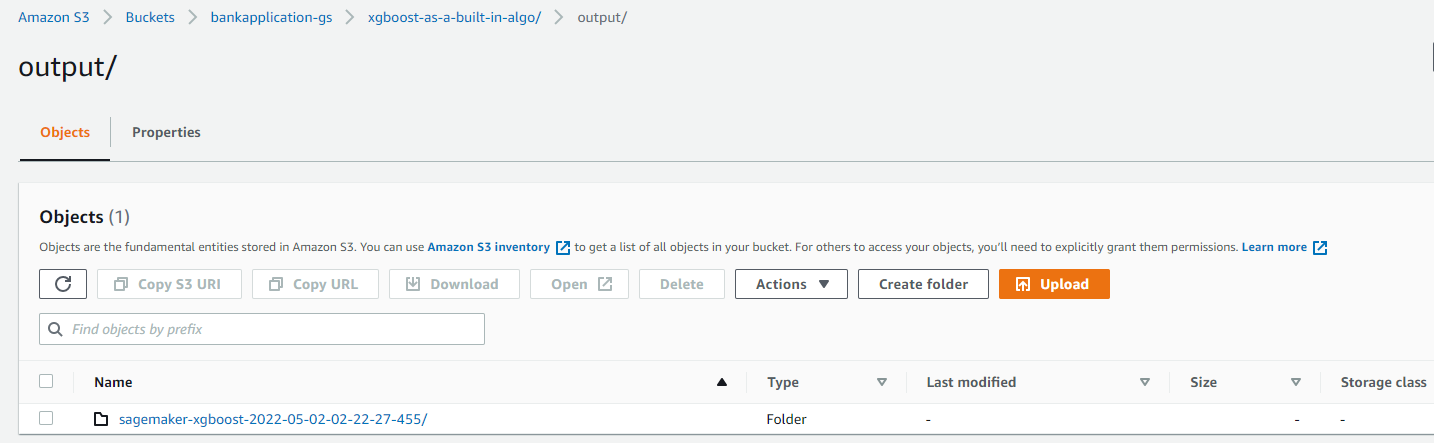

#### 6. Deploy the model

##### Required:

- **initial_instance_count:** Number of instances we want this to be deployed to.
- **instance_type:** Size of instance

In [33]:
xgb_predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-----!

#### 7. Making Prediction on the model

In [35]:
from sagemaker.predictor import csv_serializer
# load the data into an array. Since we haven't removed the Lables columns from the Test Data we are doing it now.
test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values 

# Set the serializer type
xgb_predictor.serializer = csv_serializer 

# Make Prediction
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')

# Convert prediction to Array
predictions_array = np.fromstring(predictions[1:], sep=',') 

print(predictions_array.shape)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


(12357,)


In [36]:
predictions_array

array([0.05214286, 0.05660191, 0.05096195, ..., 0.03436061, 0.02942475,
       0.03715819])

#### 8. Generate Confusion Matrix

In [37]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.7%

Predicted      No Purchase    Purchase
Observed
No Purchase    91% (10785)    34% (151)
Purchase        9% (1124)     66% (297) 



#### 9. Delete The SageMaker Endpoints

This will delete all the content from S3 and the S3 bucket we created itself.

In [38]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[{'ResponseMetadata': {'RequestId': '844EC6NXE3XJEBFZ',
   'HostId': 'wuPvk6jeARdoI12kz4tOGXBzbQqpjLTLblKH+X3gSdeXDB9WmsOnnOvTHOo1k7i+JiK2BDt5UUM=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'wuPvk6jeARdoI12kz4tOGXBzbQqpjLTLblKH+X3gSdeXDB9WmsOnnOvTHOo1k7i+JiK2BDt5UUM=',
    'x-amz-request-id': '844EC6NXE3XJEBFZ',
    'date': 'Mon, 02 May 2022 02:53:06 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'xgboost-as-a-built-in-algo/train/train.csv'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2022-05-02-02-22-27-455/profiler-output/framework/training_job_end.ts'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2022-05-02-02-22-27-455/profiler-output/system/training_job_end.ts'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2022-05-02-02-22-27-455/profiler-output/system/incremental/2022050